# Kr analysis (run 3614)

# Notebook configuration

In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Na22/run3614.dst"

In [2]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Tue Apr 25 12:21:38 2017


#### General plotting options

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [160]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange)
    x_ = np.repeat(x, y.size)
    y_ = np.tile  (y, x.size)
    z_ = z.flatten()
#    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()
    return (x, y, z, ze), plt.hist2d(x_, y_, nbin, (xrange, yrange), weights=z_), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [5]:
ifile = os.path.expandvars(inputfilename)
print("ifile:", ifile)

ifile: /Users/Gonzalo/github/NEXTdata/Na22/run3614.dst


# Read data

In [6]:
full = dstf.load_dst(ifile, "DST", "Events")
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105


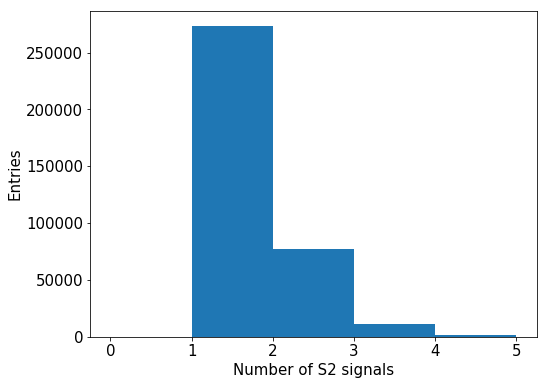

In [7]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

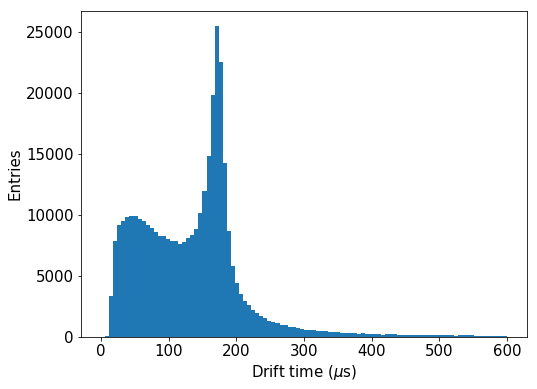

In [8]:
hist(full.Z, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")

# S2 energy vs Z

0.446876532499 [ 8728.45736731  -342.68687384] [ 47.42925695   6.63597484]
0.172773389638 [ 8615.69050924  -333.53907314] [ 31.93346452   4.19531225]


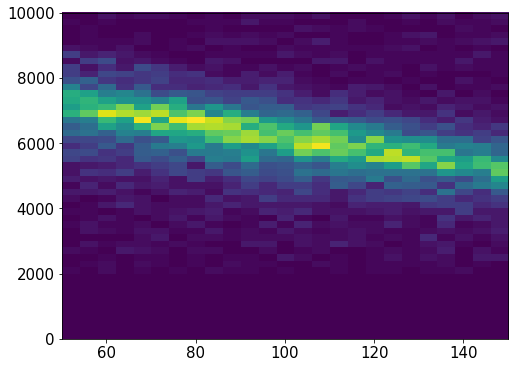

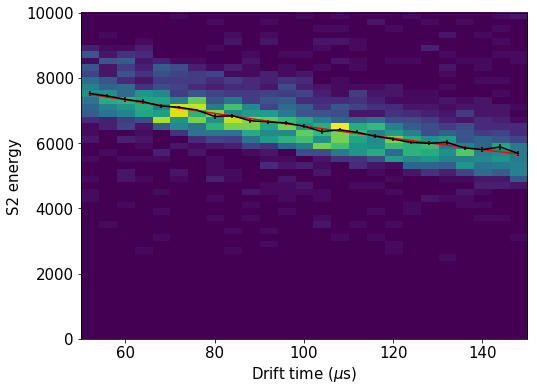

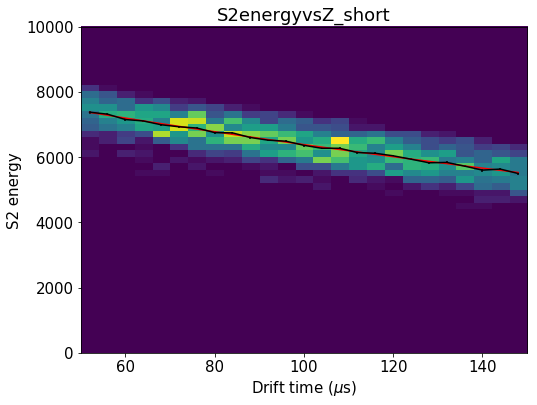

In [48]:
zrange = 50, 150
Erange = 0, 1e4

data = full[coref.in_range(full.R, 0, 100) & coref.in_range(full.S2e, 2e3, 1e4)]
fid = coref.in_range(data.S2e, 6500 - 250/17*data.Z, 9000 - data.Z * 300/17)


hist2d(full.Z, full.S2e, (25, 50), range=(zrange, Erange))

hist2d(data.Z, data.S2e, (25, 50), range=(zrange, Erange))
x, y, ye = fitf.profileX(data.Z, data.S2e, 25, xrange=zrange)
plt.errorbar(x, y, ye, None, "k")

f = fitf.fit(fitf.expo, x, y, (8e3, -4e2), sigma=ye)
plt.plot(x, f.fn(x), "r-")
print(f.chi2, f.values, f.errors)

labels("Drift time ($\mu$s)", "S2 energy")

hist2d(data.Z[fid], data.S2e[fid], (25, 50), range=(zrange, Erange))
x, y, ye = fitf.profileX(data.Z[fid], data.S2e[fid], 25, xrange=zrange)
#print((1-y/y0)*100)
plt.errorbar(x, y, ye, None, "k")

f = fitf.fit(fitf.expo, x, y, (8e3, -4e2), sigma=ye)
plt.plot(x, f.fn(x), "r-")
print(f.chi2, f.values, f.errors)
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zfun  = f.fn
zcorr = lambda z: zfun(50)/zfun(z)

# X-rays

In [96]:
XRrange = 2e3, 1e4
XR = full[coref.in_range(full.S2e, 4500, 9000) & coref.in_range(full.R, 0, 180)  & coref.in_range(full.Z, 0, 150)]
XR.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
45,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
319,333,1.491674e+09,1,2,150.0,10.558423,52.607425,626750.0,5.023438,2293.554688,...,686687.5,4,59.9375,59.9375,-138.539810,-30.162793,141.785306,-2.927219,4.792442,5.008226
385,400,1.491674e+09,1,2,250.0,11.551735,69.007702,633700.0,4.361688,3391.495117,...,669612.5,5,35.9125,35.9125,3.795978,-40.973047,41.148512,-1.478414,5.992984,4.914148
491,516,1.491674e+09,1,2,200.0,22.708979,117.548693,578400.0,6.854375,1850.171021,...,680437.5,2,102.0375,102.0375,85.000000,-99.869028,131.144282,-0.865655,0.000000,5.020116
544,574,1.491674e+09,1,2,150.0,11.854716,55.409155,618325.0,4.847688,2736.931641,...,671012.5,2,52.6875,52.6875,-75.000000,108.964498,132.280996,2.173625,0.000000,4.910066


# S2 energy

[  1.34070782e+06   7.19063986e+03   5.87617012e+02] (19.204132111305537, 2.1074127401728888)


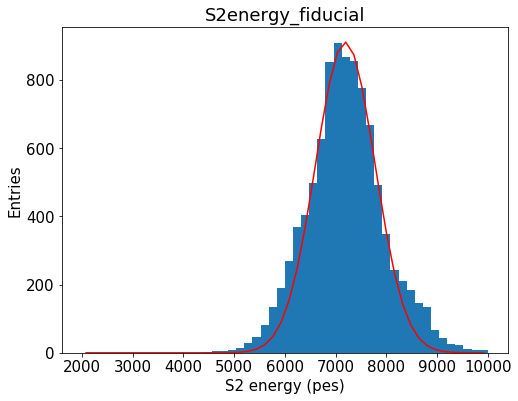

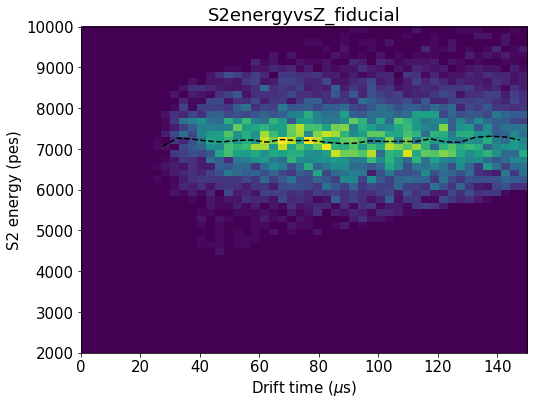

In [97]:
zrange = 0, 150
Erange = XRrange

y, x, _ = \
hist(XR.S2e * zcorr(XR.Z), 50, range=Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])
seed = 1e6, 7e3, 6e2
f = fitf.fit(fun, x, y, seed, fit_range=(6500, 8000))
plt.plot(x, f.fn(x), "r-")
print(f.values, reso(f.values[:3], 29.6))

labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(XR.Z, XR.S2e * zcorr(XR.Z), (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(XR.Z, XR.S2e* zcorr(XR.Z), 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")


# Energy vs position

7555.00206898


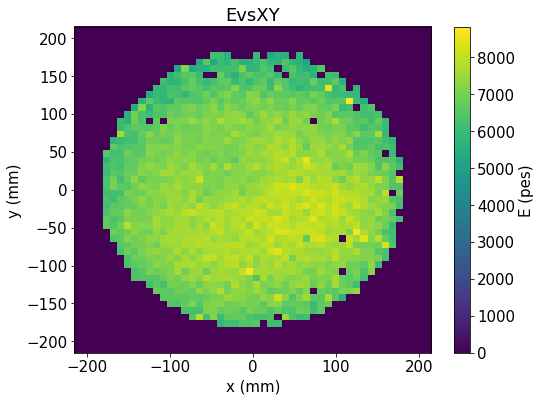

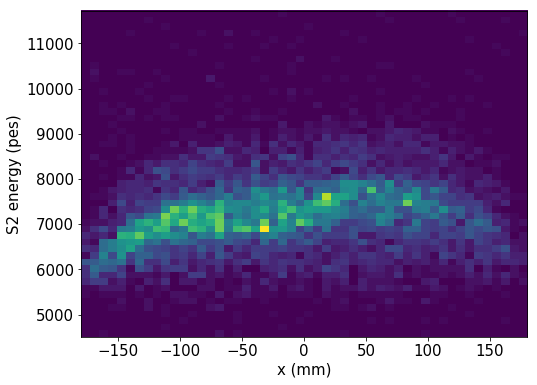

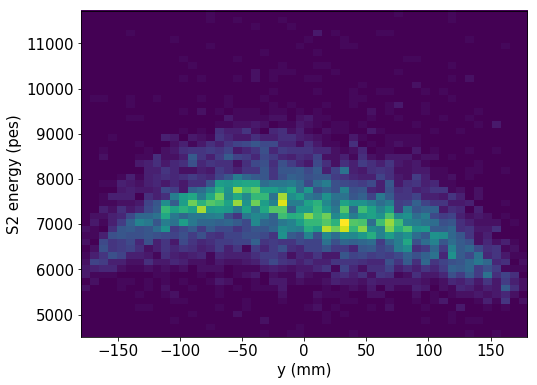

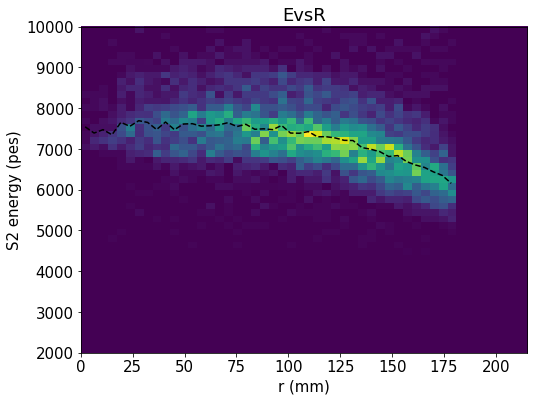

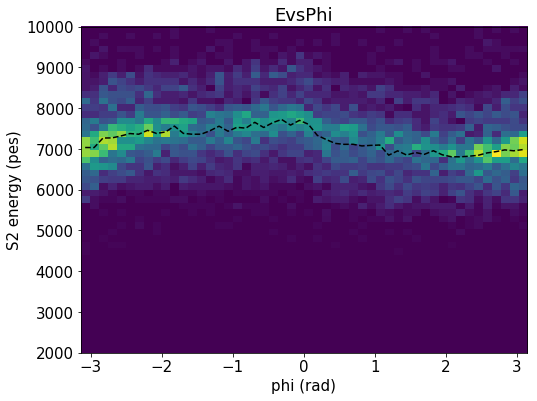

In [98]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  XRrange

E = XR.S2e * zcorr(XR.Z)

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

hist2d(XR.X, E, 50)
labels("x (mm)", "S2 energy (pes)")

hist2d(XR.Y, E, 50)
labels("y (mm)", "S2 energy (pes)")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

[  6.01880685e+05   7.38175742e+03   3.15193383e+02   1.33607264e+05
   8.29813996e+03   2.90149945e+02]


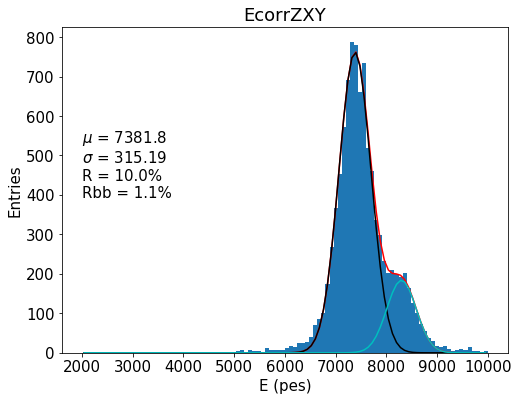

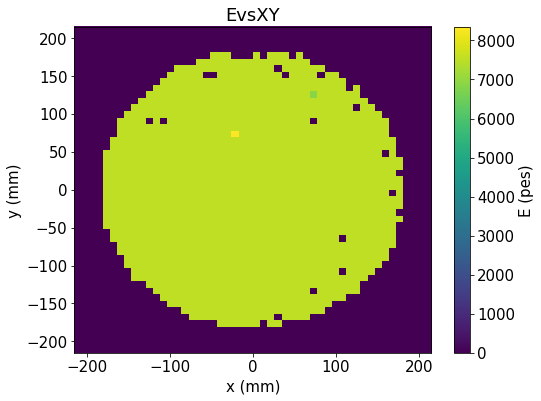

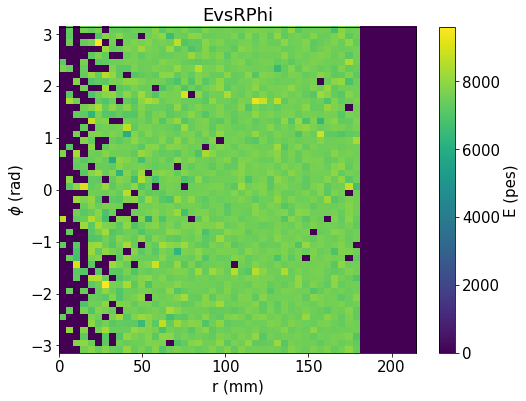

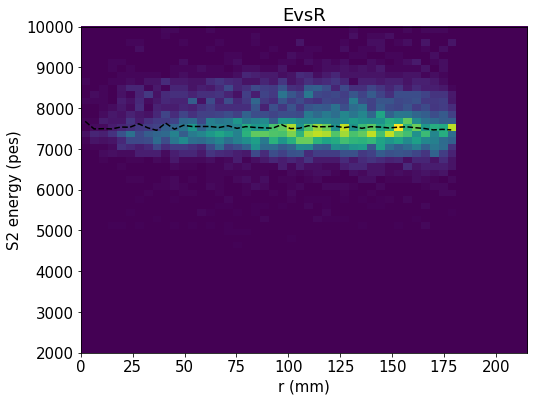

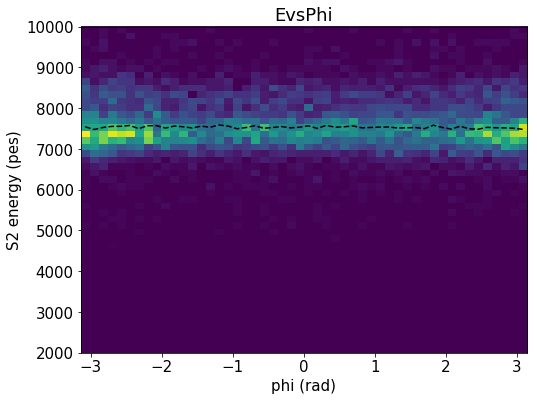

In [99]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  XRrange

E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 100, Erange)

x    = x[:-1] + np.diff(x) * 0.5
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e3, 7500, 100, 1e3, 9000, 200
low  =  10, 7000,  50,  10, 8000, 100
upp  = 5e6, 8200, 800, 5e5, 9200, 800
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 10000), bounds=(low, upp))
print(f.values)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


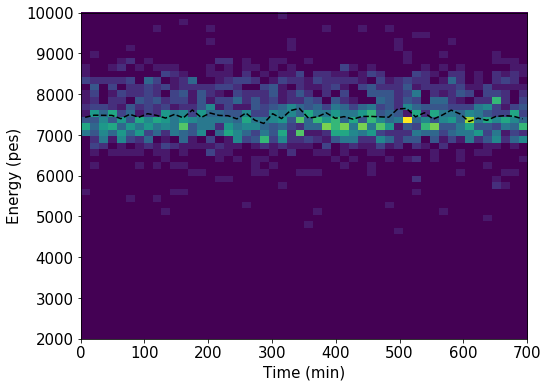

In [100]:
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)
T = (XR.time - np.min(XR.time))/60

Erange = XRrange
Trange = 0, 700

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

[  1.20964083e+06   7.62446960e+03   3.36720617e+02   2.63689618e+05
   8.57368090e+03   3.11112932e+02]


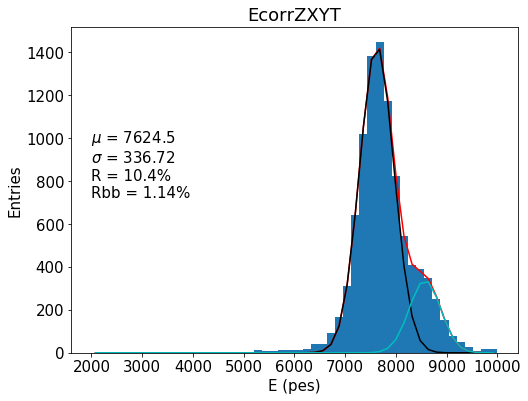

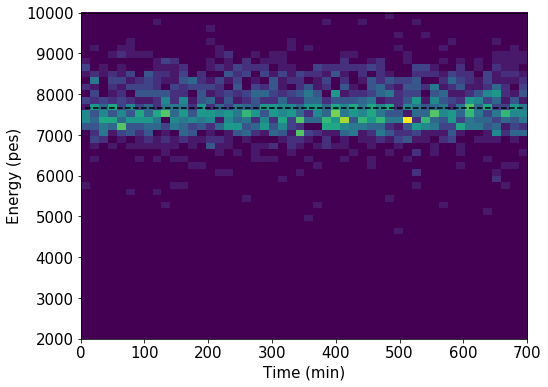

In [101]:
T = (XR.time - np.min(XR.time))/60
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values) * tcorr(T)

Trange = 0, 700
Erange = XRrange

y, x, _ = hist(E, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e3, 7500, 100, 1e3, 9000, 200
low  =  10, 7000,  50,  10, 8000, 100
upp  = 5e6, 8200, 800, 5e5, 9200, 800
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 10000), bounds=(low, upp))
print(f.values)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")


In [225]:
PP = full[coref.in_range(full.S1e, 100, 150)]
PP = PP[coref.in_range(PP.S2e, 50e3, 110e3)]
PP = PP[coref.in_range(PP.S2e * zcorr(PP.Z) * xycorr(PP.X.values, PP.Y.values), 110e3, 150e3)]
PP = PP[coref.in_range(PP.X, -100, -10)]
PP = PP[coref.in_range(PP.Y, -20, 20)]
PP = PP[PP.nS2==1]
#PP = PP[coref.in_range(PP.Xrms, 9.2, 10.2)]
#PP = PP[coref.in_range(PP.Yrms, 9.2, 10.2)]
PP.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
15,18,1.491674e+09,0,1,200.0,26.175219,133.905174,492500.0,21.042875,8758.824219,...,660787.5,25,168.2875,168.2875,-68.850136,-6.777933,69.182957,-3.043464,10.565948,10.399427
35,40,1.491674e+09,0,1,225.0,23.022671,128.208851,489000.0,16.946125,15193.394531,...,655687.5,27,166.6875,166.6875,-21.223483,-6.482483,22.191413,-2.845153,11.479459,11.552235
40,45,1.491674e+09,0,1,225.0,26.017241,143.136587,488875.0,13.971125,14698.360352,...,657512.5,29,168.6375,168.6375,-16.200915,-4.581660,16.836308,-2.865987,11.178634,11.733388
86,96,1.491674e+09,0,1,200.0,26.796915,134.617890,501600.0,22.125000,12878.622070,...,654637.5,25,153.0375,153.0375,-24.196011,-16.803718,29.458647,-2.534579,9.003460,11.566005
93,101,1.491674e+09,0,1,225.0,26.018654,136.695419,481025.0,24.553750,9104.865234,...,658962.5,23,177.9375,177.9375,-93.383576,-6.498554,93.609420,-3.072115,9.918896,10.189859


[  3.61745153e+06   1.21522413e+05   3.64330142e+03   1.53970714e+01]


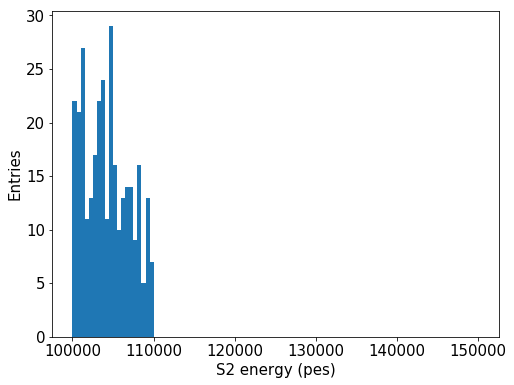

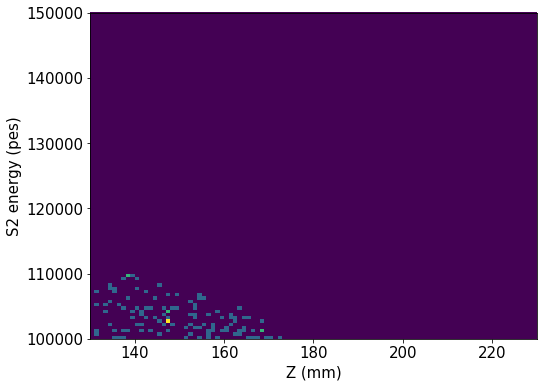

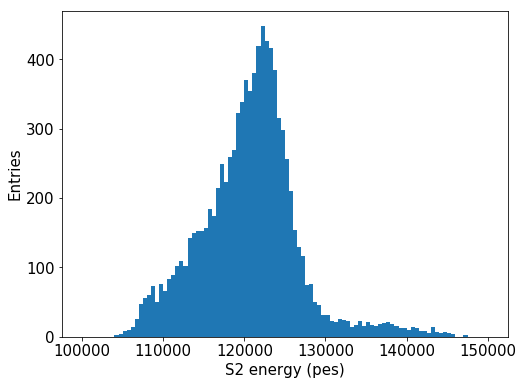

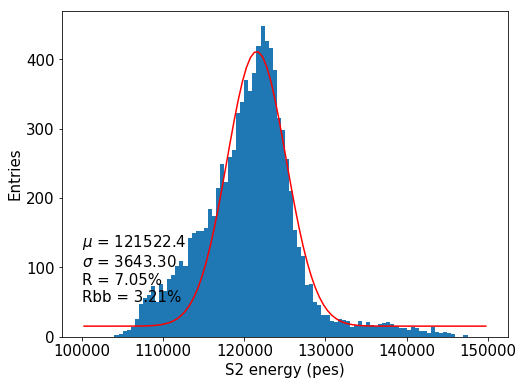

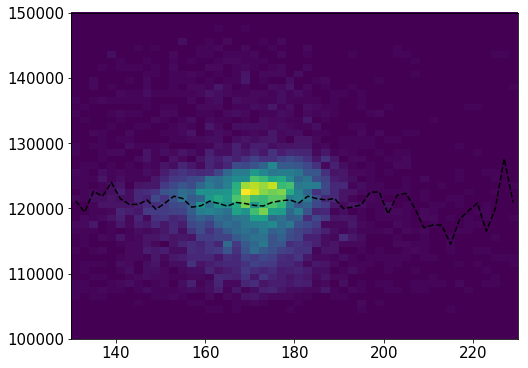

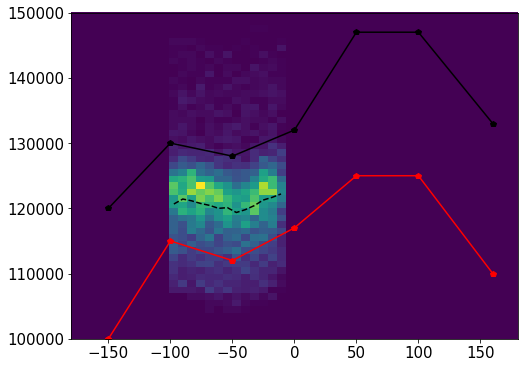

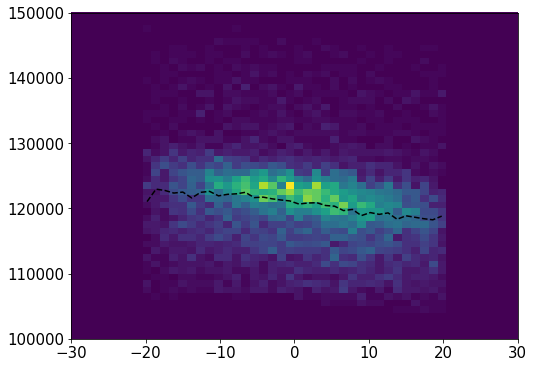

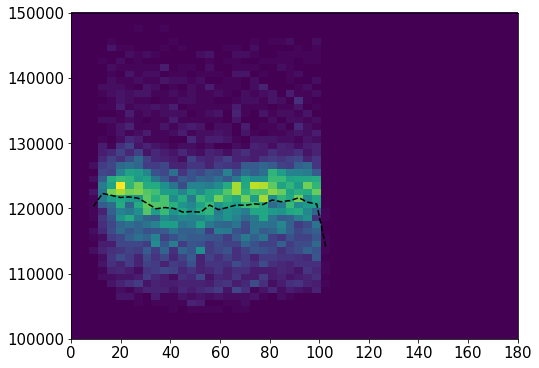

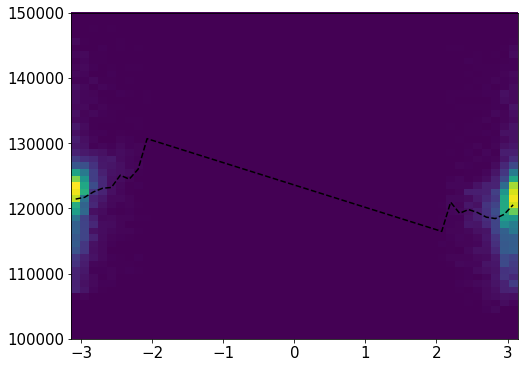

In [226]:
import scipy as sc
import scipy.interpolate

xrange = -180, 180
yrange = - 30,  30
rrange =    0, 180
prange = -pi ,  pi
zrange =  130, 230
Erange = 10e4, 150e3


_x    = np.array([-150,   -100,   -50,     0,   50,   100,    160])
_emin = np.array([100e3, 115e3, 112e3, 117e3, 125e3, 125e3, 110e3])
_emax = np.array([120e3, 130e3, 128e3, 132e3, 147e3, 147e3, 133e3])

_eminfid = sc.interpolate.interp1d(_x, _emin, fill_value="extrapolate")
_emaxfid = sc.interpolate.interp1d(_x, _emax, fill_value="extrapolate")

hist(PP.S2e, 100, Erange)
labels("S2 energy (pes)", "Entries")

hist2d(PP.Z, PP.S2e, 100, (zrange,Erange))
labels("Z (mm)", "S2 energy (pes)")

hist(PP.S2e * zcorr(PP.Z), 100, Erange)
labels("S2 energy (pes)", "Entries")

E = PP.S2e * zcorr(PP.Z)# * xycorr(PP.X.values, PP.Y.values)
y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
fun = lambda x, A, mu, sig, a: fitf.gauss(x, A, mu, sig) + a
f = fitf.fit(fun, x, y, (1e8, 12e4, 1e3, 10), fit_range=(115e3, 14e4))
plt.plot(x, f.fn(x), fitOpt)

plt.text(Erange[0], 50, gausstext(f.values[:3], 511))
print(f.values)
labels("S2 energy (pes)", "Entries")


hist2d(PP.Z, E, 50, range=(zrange, Erange))
x, y, _ = fitf.profileX(PP.Z, E, 50, zrange)
plt.plot(x, y, profOpt)

hist2d(PP.X, E, 50, range=(xrange, Erange))
x, y, _ = fitf.profileX(PP.X, E, 50, xrange)
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")

hist2d(PP.Y, E, 50, range=(yrange, Erange))
x, y, _ = fitf.profileX(PP.Y, E, 50, yrange)
plt.plot(x, y, profOpt)

hist2d(PP.R, E, 50, range=(rrange, Erange))
x, y, _ = fitf.profileX(PP.R, E, 50, rrange)
plt.plot(x, y, profOpt)

hist2d(PP.Phi, E, 50, range=(prange, Erange))
x, y, _ = fitf.profileX(PP.Phi, E, 50, prange)
plt.plot(x, y, profOpt)

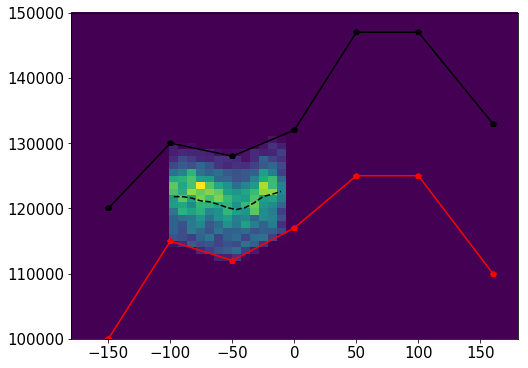

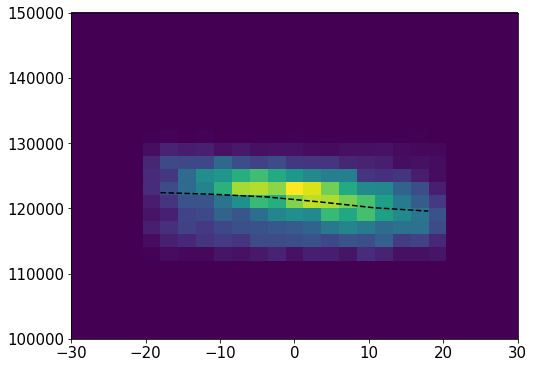

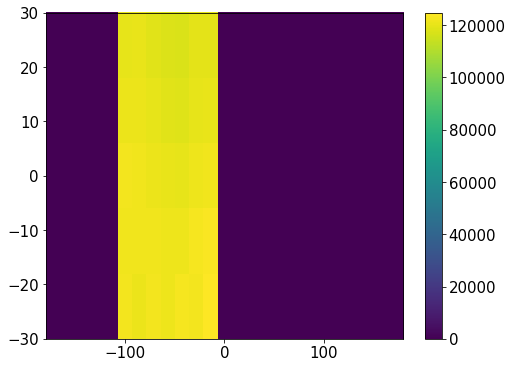

In [227]:
E = PP.S2e * zcorr(PP.Z)

sel = coref.in_range(E, _eminfid(PP.X.values), _emaxfid(PP.X.values))

hist2d(PP.X[sel], E[sel], 50, range=(xrange, Erange))
x, y, _ = fitf.profileX(PP.X[sel], E[sel], 50, xrange)
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")

hist2d(PP.Y[sel], E[sel], 25, range=(yrange, Erange))
x, y, _ = fitf.profileX(PP.Y[sel], E[sel], 50, xrange)
plt.plot(x, y, profOpt)


profile_and_scatter(PP.X[sel], PP.Y[sel], E[sel], (25, 5), xrange, yrange);

125000.0


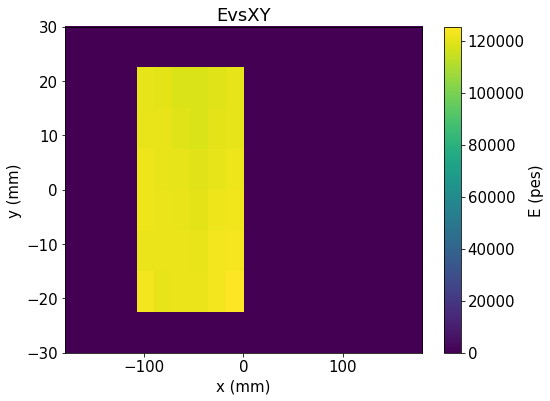

In [228]:
E = PP.S2e * zcorr(PP.Z)

sel = coref.in_range(E, _eminfid(PP.X.values), _emaxfid(PP.X.values))

pf, _, cb = profile_and_scatter(PP.X[sel], PP.Y[sel], E[sel], (20, 8), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")
xycorr = get_xycorr(*pf[:-1], 125e3)

[  3.12171465e+06   1.25969787e+05   2.79986916e+03]
[  1.23229076e+05   1.93313279e-02]


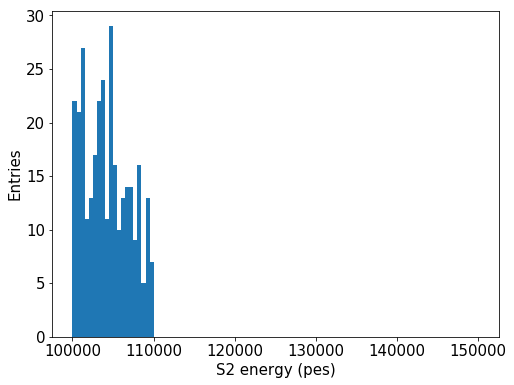

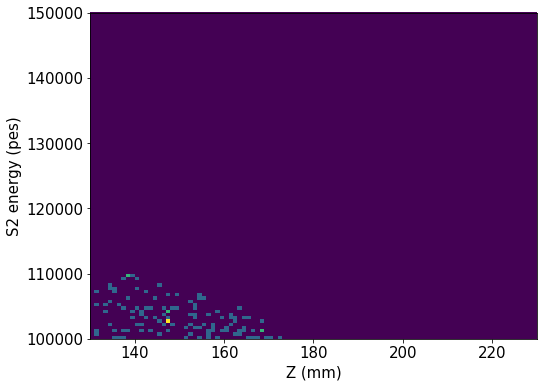

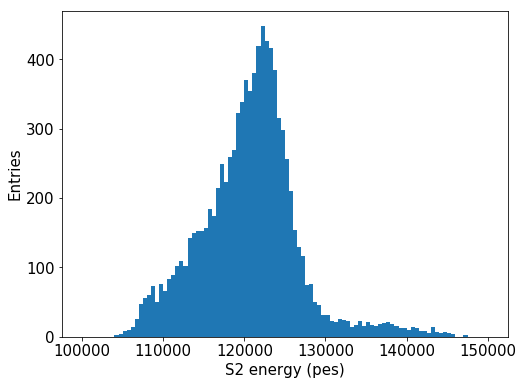

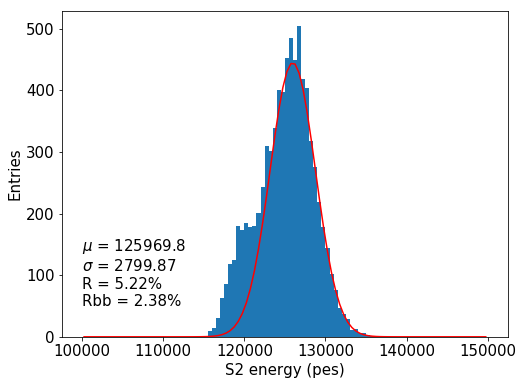

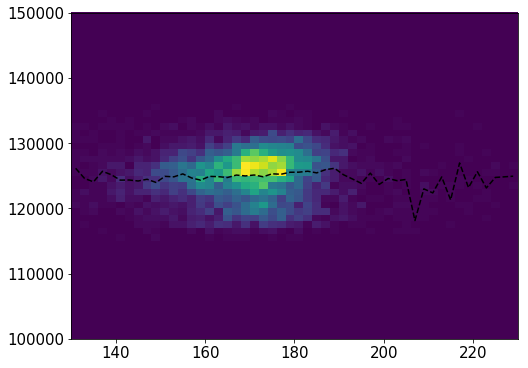

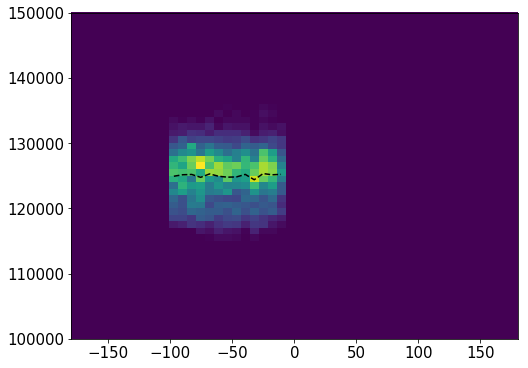

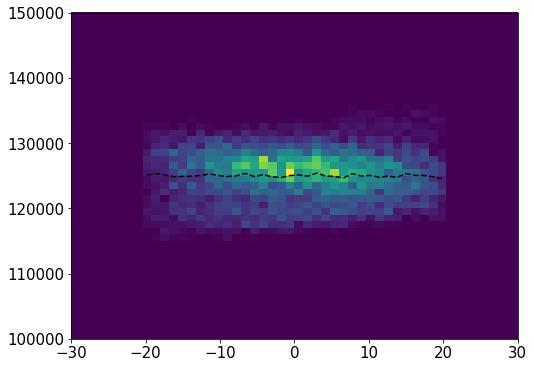

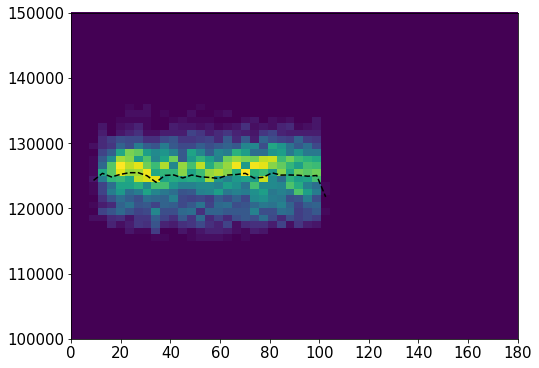

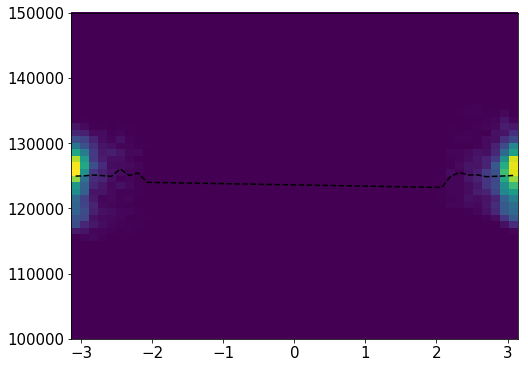

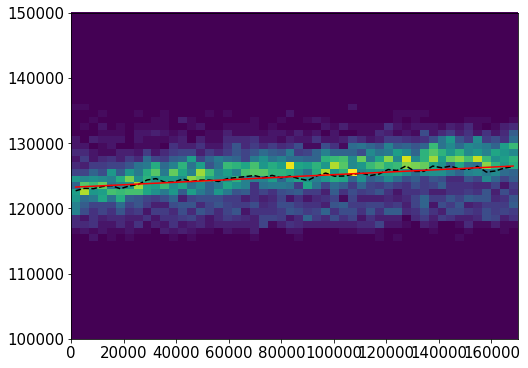

In [235]:
xrange = -180, 180
yrange = - 30,  30
rrange =    0, 180
prange = -pi ,  pi
zrange =  130, 230
Erange = 10e4, 150e3

hist(PP.S2e, 100, Erange)
labels("S2 energy (pes)", "Entries")

hist2d(PP.Z, PP.S2e, 100, (zrange,Erange))
labels("Z (mm)", "S2 energy (pes)")

hist(PP.S2e * zcorr(PP.Z), 100, Erange)
labels("S2 energy (pes)", "Entries")

E = PP.S2e * zcorr(PP.Z) * xycorr(PP.X.values, PP.Y.values)
y, x, _ = hist(E[sel], 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
fun = lambda x, A, mu, sig, a=0: fitf.gauss(x, A, mu, sig) + a
f = fitf.fit(fun, x, y, (1e8, 125e3, 1e3), fit_range=(128e3, 135e3))
plt.plot(x, f.fn(x), fitOpt)

plt.text(Erange[0], 50, gausstext(f.values[:3], 511))
print(f.values)
labels("S2 energy (pes)", "Entries")


hist2d(PP.Z[sel], E[sel], 50, range=(zrange, Erange))
x, y, _ = fitf.profileX(PP.Z[sel], E[sel], 50, zrange)
plt.plot(x, y, profOpt)

hist2d(PP.X[sel], E[sel], 50, range=(xrange, Erange))
x, y, _ = fitf.profileX(PP.X[sel], E[sel], 50, xrange)
plt.plot(x, y, profOpt)

hist2d(PP.Y[sel], E[sel], 50, range=(yrange, Erange))
x, y, _ = fitf.profileX(PP.Y[sel], E[sel], 50, yrange)
plt.plot(x, y, profOpt)

hist2d(PP.R[sel], E[sel], 50, range=(rrange, Erange))
x, y, _ = fitf.profileX(PP.R[sel], E[sel], 50, rrange)
plt.plot(x, y, profOpt)

hist2d(PP.Phi[sel], E[sel], 50, range=(prange, Erange))
x, y, _ = fitf.profileX(PP.Phi[sel], E[sel], 50, prange)
plt.plot(x, y, profOpt)

T = PP.time[sel] - np.min(PP.time[sel])
hist2d(T, E[sel], 50, range=((0,170e3), Erange))
x, y, _ = fitf.profileX(T, E[sel], 50, (0, 170e3))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (120e3, 2))
print(f.values)
plt.plot(x, f.fn(x), "r-")

tfun = f.fn
tcorr = lambda t: tfun(0)/tfun(t)

[  3.25882053e+06   1.24056890e+05   2.28874482e+03]
[  1.23228373e+05   7.57334481e-06]


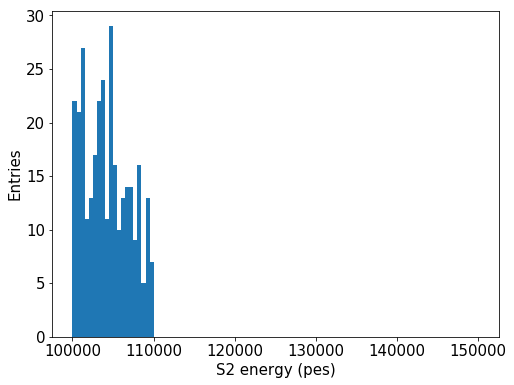

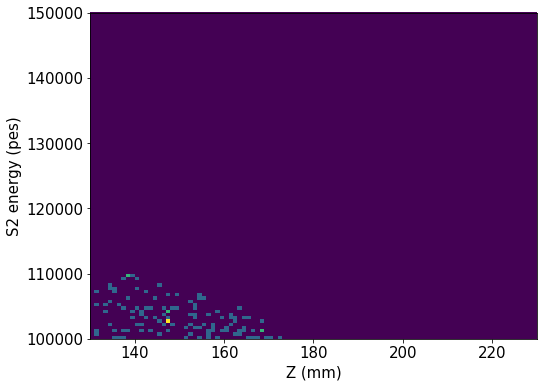

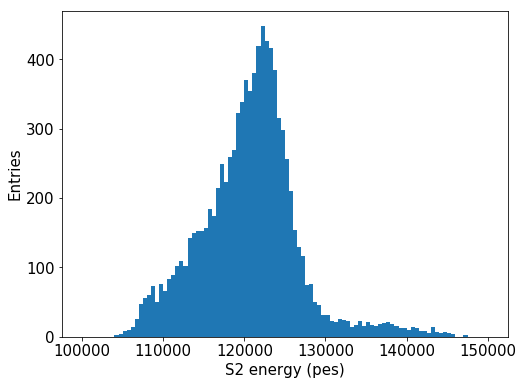

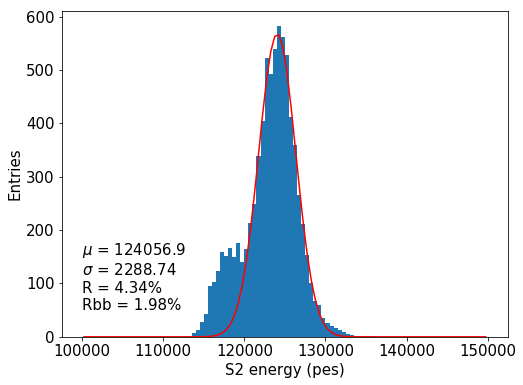

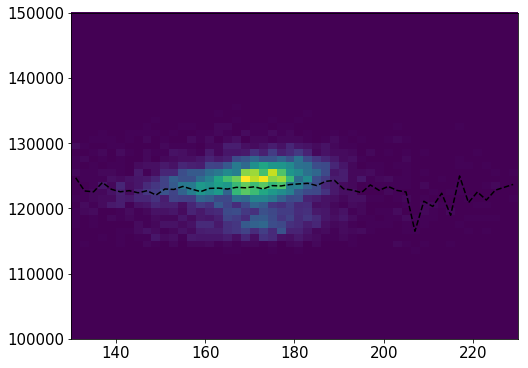

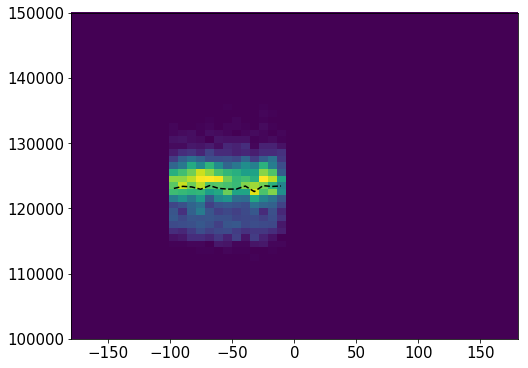

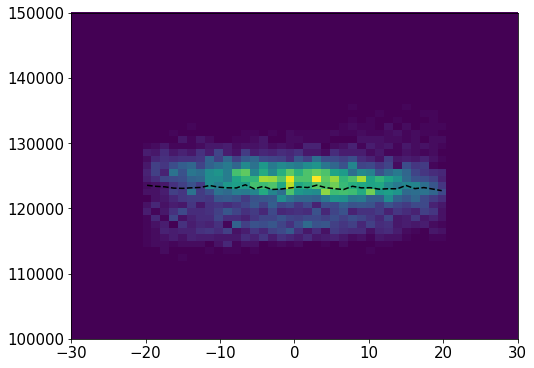

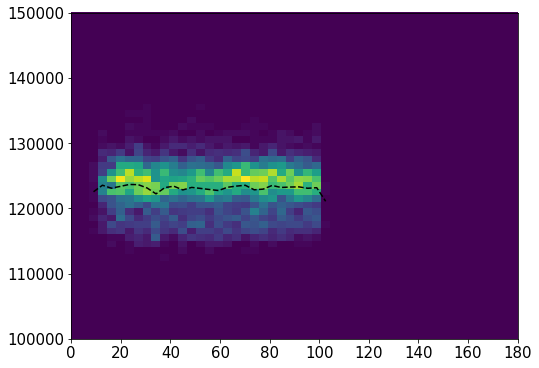

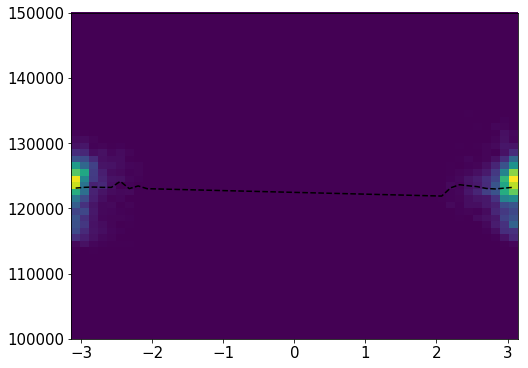

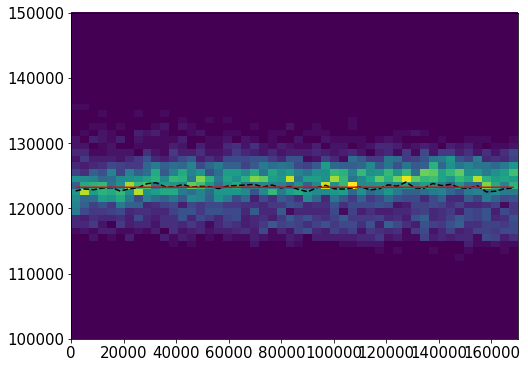

In [252]:
xrange = -180, 180
yrange = - 30,  30
rrange =    0, 180
prange = -pi ,  pi
zrange =  130, 230
Erange = 10e4, 150e3

hist(PP.S2e, 100, Erange)
labels("S2 energy (pes)", "Entries")

hist2d(PP.Z, PP.S2e, 100, (zrange,Erange))
labels("Z (mm)", "S2 energy (pes)")

hist(PP.S2e * zcorr(PP.Z), 100, Erange)
labels("S2 energy (pes)", "Entries")

E = PP.S2e * zcorr(PP.Z) * xycorr(PP.X.values, PP.Y.values) * tcorr(PP.time.values - np.min(PP[sel].time.values))
y, x, _ = hist(E[sel], 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
#fun = lambda x, A, mu, sig, B, C: fitf.gauss(x, A, mu, sig) + fitf.polynom(x, B, C)
#seed = 1e8, 125e3, 1e3, 1e7, -1e3

fun = lambda x, A, mu, sig: fitf.gauss(x, A, mu, sig)
seed = 1e8, 125e3, 1e3


f = fitf.fit(fun, x, y, seed, fit_range=(120e3, 130e3))

plt.plot(x, f.fn(x), fitOpt)
#plt.plot(x, fitf.gauss(x, *f.values[:3]), "k-")
#plt.plot(x, fitf.polynom(x, *f.values[3:]), "m-")

plt.text(Erange[0], 50, gausstext(f.values[:3], 511))
print(f.values)
labels("S2 energy (pes)", "Entries")


hist2d(PP.Z[sel], E[sel], 50, range=(zrange, Erange))
x, y, _ = fitf.profileX(PP.Z[sel], E[sel], 50, zrange)
plt.plot(x, y, profOpt)

hist2d(PP.X[sel], E[sel], 50, range=(xrange, Erange))
x, y, _ = fitf.profileX(PP.X[sel], E[sel], 50, xrange)
plt.plot(x, y, profOpt)

hist2d(PP.Y[sel], E[sel], 50, range=(yrange, Erange))
x, y, _ = fitf.profileX(PP.Y[sel], E[sel], 50, yrange)
plt.plot(x, y, profOpt)

hist2d(PP.R[sel], E[sel], 50, range=(rrange, Erange))
x, y, _ = fitf.profileX(PP.R[sel], E[sel], 50, rrange)
plt.plot(x, y, profOpt)

hist2d(PP.Phi[sel], E[sel], 50, range=(prange, Erange))
x, y, _ = fitf.profileX(PP.Phi[sel], E[sel], 50, prange)
plt.plot(x, y, profOpt)

T = PP.time[sel] - np.min(PP.time[sel])
hist2d(T, E[sel], 50, range=((0,170e3), Erange))
x, y, _ = fitf.profileX(T, E[sel], 50, (0, 170e3))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (120e3, 2))
print(f.values)
plt.plot(x, f.fn(x), "r-")